In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import wordcloud

import re
from utils.dataset import ViContextHSD
from typing import Callable, Any

emoticon_regex = re.compile("(["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u'\U00010000-\U0010ffff'
    u"\u200d"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\u3030"
    u"\ufe0f"
    u"\u221a"
"])")

def simple_split(sentence: str):
    splitted = " ".join(emoticon_regex.split(sentence)).split()
    return splitted

def display_bar_num(ax, predicate: Callable[[Any], Any] = lambda x: x):
    for container in ax.containers:
        ax.bar_label(container, labels=map(predicate, container.datavalues))

In [11]:
df = pd.concat([
    ViContextHSD(split).df.assign(split=split)
    for split in ("train", "dev", "test")
])
df["label"] = df["label"].map({0: "Clean", 1: "Offensive", 2: "Hate"})

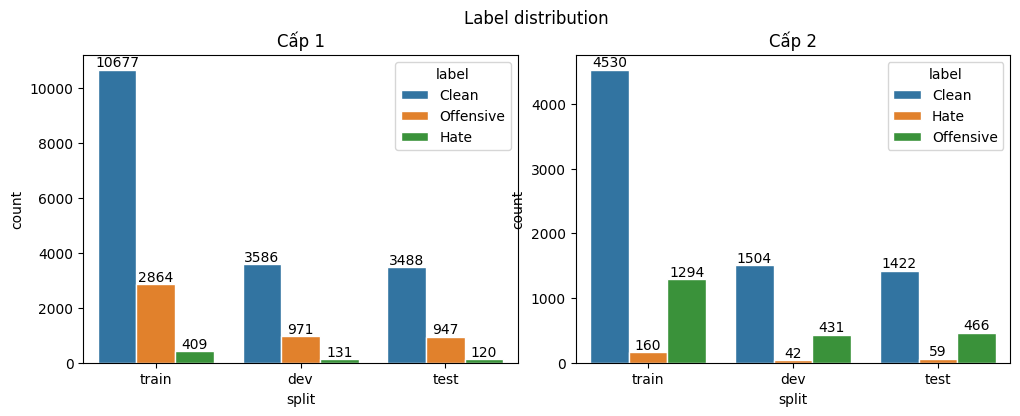

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Label distribution")
fig.tight_layout()
for lvl, a in enumerate(ax, start=1):
    sns.countplot(df[df["level"] == lvl], x="split", hue="label", ax=a, edgecolor="white").set(title=f"Cấp {lvl}")
    display_bar_num(a, lambda v: int(v))

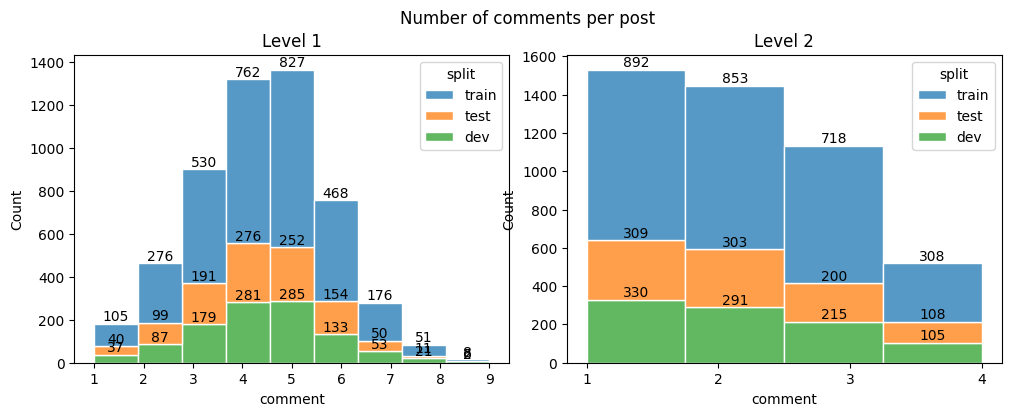

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Number of comments per post")
fig.tight_layout()
for lvl, a in enumerate(ax, start=1):
    count = df[df["level"] == lvl].groupby(["image", "split"])[["comment"]].count()
    max_count = count["comment"].max()
    sns.histplot(count, x="comment", hue="split", ax=a, bins=max_count, edgecolor="white", multiple="stack").set(
        title=f"Level {lvl}", 
        xticks=range(1, max_count+1)
    )
    display_bar_num(a, int)

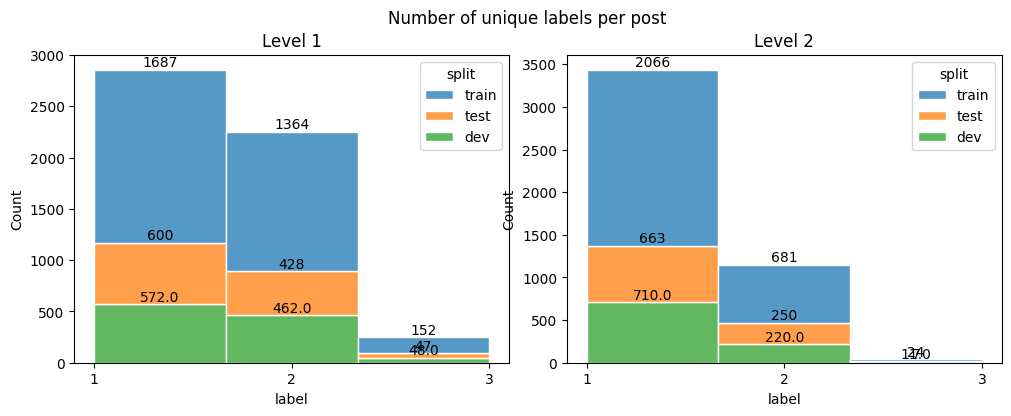

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Number of unique labels per post")
fig.tight_layout()
for lvl, a in enumerate(ax, start=1):
    count = df[df["level"] == lvl].groupby(["image", "split"])[["label"]].nunique()
    max_count = count["label"].max()
    sns.histplot(count, x="label", hue="split", ax=a, bins=max_count, edgecolor="white", multiple="stack").set(
        title=f"Level {lvl}", 
        xticks=range(1, max_count+1)
    )
    display_bar_num(a)

[Text(0.5, 1.0, 'Comment Level 2'), Text(0.5, 14.722222222222216, 'Length')]

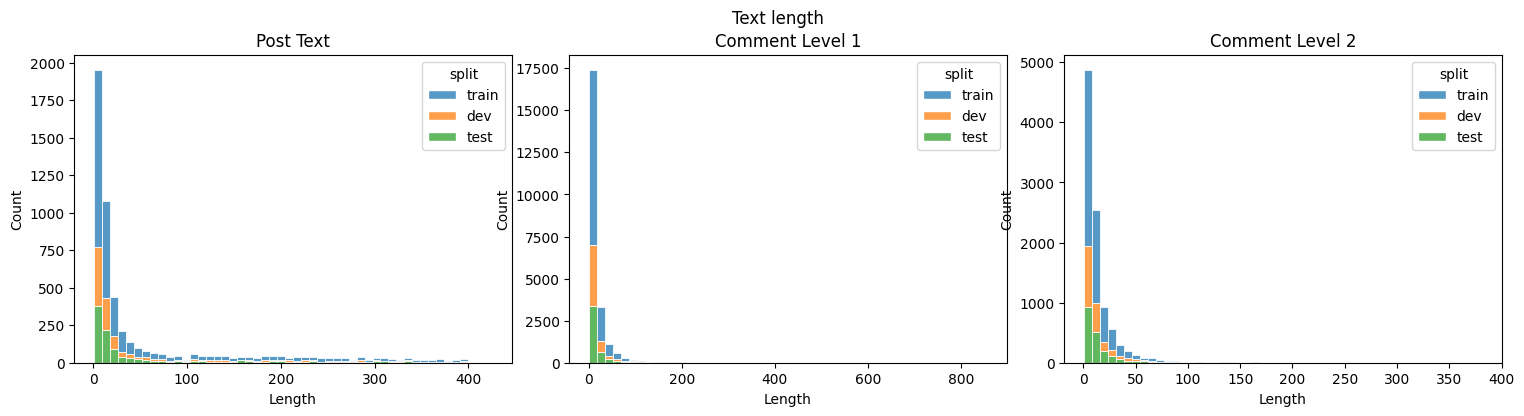

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Text length")
fig.tight_layout()
sns.histplot(x=df.drop_duplicates("image")["caption"].map(lambda s: len(simple_split(s))).values, 
             hue=df.drop_duplicates("image")["split"],
             multiple="stack",
             bins=50,
             edgecolor="white",
             ax=ax[0]) \
    .set(title="Post Text",
         xlabel="Length")
sns.histplot(x=df.loc[df.level == 1, "comment"].map(lambda s: len(simple_split(s))).values, 
             hue=df.loc[df.level == 1, "split"],
             multiple="stack",
             bins=50,
             edgecolor="white",
             ax=ax[1]) \
    .set(title="Comment Level 1",
         xlabel="Length")
sns.histplot(x=df.loc[df.level == 2, "comment"].map(lambda s: len(simple_split(s))).values, 
             hue=df.loc[df.level == 2, "split"],
             multiple="stack",
             bins=50,
             edgecolor="white",
             ax=ax[2]) \
    .set(title="Comment Level 2",
         xlabel="Length")

(0.0, 1.0, 0.0, 1.0)

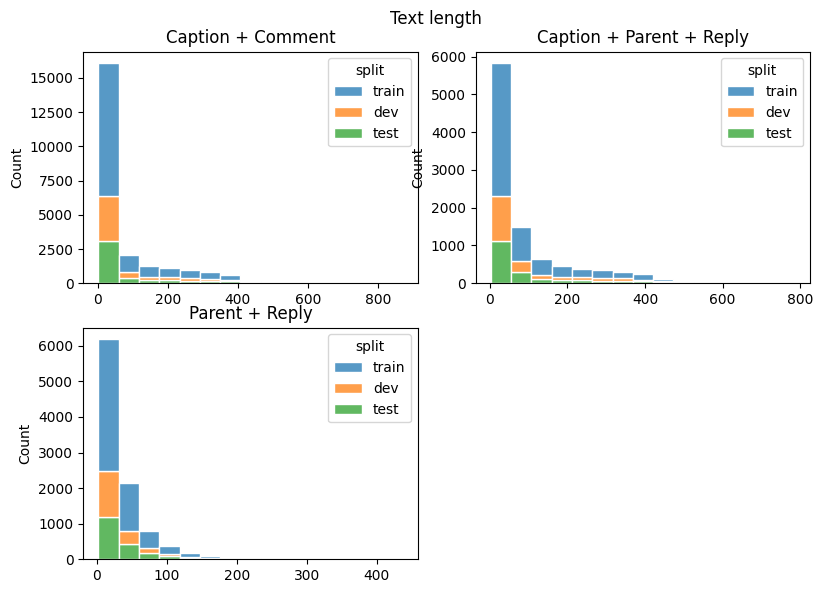

In [16]:
fig, ax = plt.subplots(2,2, figsize=(8,6))
fig.suptitle("Text length")
fig.tight_layout()
lvl2_df = df[df["level"] == 2].drop(columns="comment_id").rename(columns={"parent": "comment_id"}).merge(df[df["level"] == 1], on="comment_id")[["caption_x", "comment_y", "comment_x", "split_x"]].rename(columns={"caption_x": "caption", "comment_y": "parent", "comment_x": "reply", "split_x": "split"})
sns.histplot(x=df.loc[df.level == 1, ["caption", "comment"]].map(lambda s: len(simple_split(s))).sum(axis=1).values, 
             hue=df.loc[df.level == 1, "split"],
             multiple="stack",
             bins=15,
             edgecolor="white",
             ax=ax[0,0]) \
    .set(title="Caption + Comment")
sns.histplot(x=lvl2_df[["caption", "parent", "reply"]].map(lambda s: len(simple_split(s))).sum(axis=1).values, 
             hue=lvl2_df["split"],
             multiple="stack",
             bins=15,
             edgecolor="white",
             ax=ax[0,1]) \
    .set(title="Caption + Parent + Reply")
sns.histplot(x=lvl2_df[["parent", "reply"]].map(lambda s: len(simple_split(s))).sum(axis=1).values, 
             hue=lvl2_df["split"],
             multiple="stack",
             bins=15,
             edgecolor="white",
             ax=ax[1,0]) \
    .set(title="Parent + Reply")

ax[1, 1].axis("off")

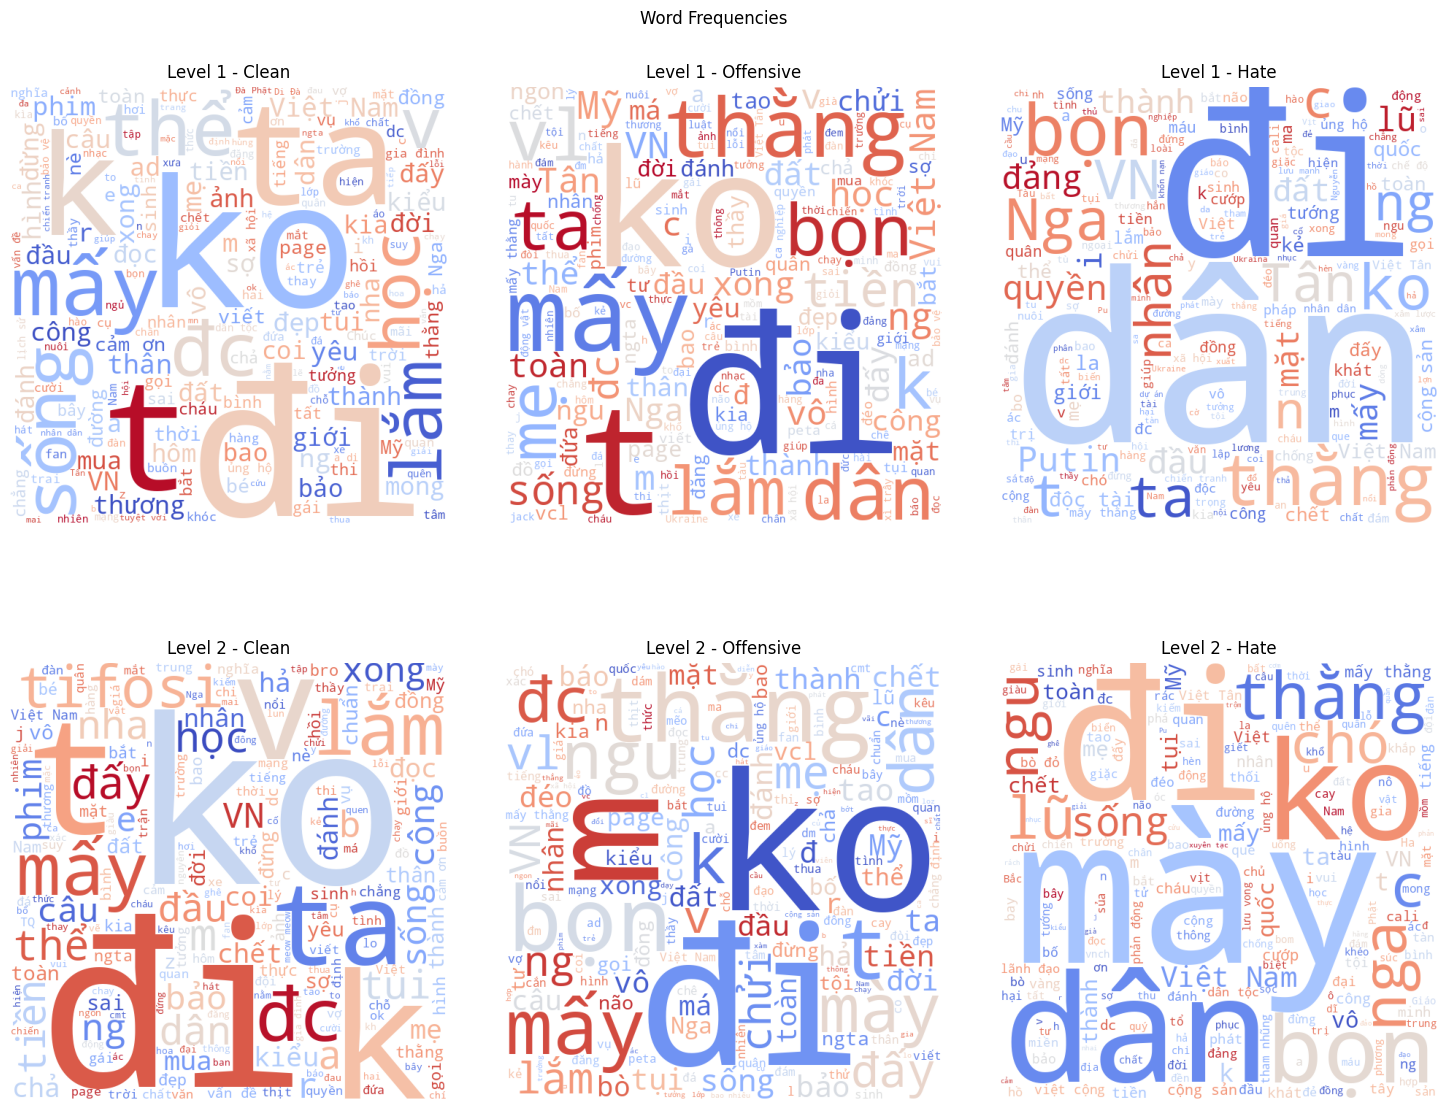

In [19]:
fig, ax = plt.subplots(2, 3, figsize=(15, 12))
fig.suptitle("Word Frequencies")
fig.tight_layout()
wc_size = 600

with open("vietnamese-stopwords.txt") as f:
    stopwords = f.read().split("\n") + ["username"]
wc = wordcloud.WordCloud(
    width=wc_size,
    height=wc_size,
    colormap="coolwarm",
    background_color="white",
    min_word_length=1,
    stopwords=stopwords
)

for i, lvl in enumerate(["Level 1", "Level 2"]):
    for j, lbl in enumerate(["Clean", "Offensive", "Hate"]):
        df_filtered = df[(df["level"] == i+1) & (df["label"] == lbl)]
        img = wc.generate(" ".join(df_filtered["comment"]))
        ax[i, j].imshow(img)
        ax[i, j].set_title(f"{lvl} - {lbl}")
        ax[i, j].axis("off")

In [ ]:
from utils.preprocess_text import normalize

for i, label in enumerate(["Clean", "Offensive", "Hate"]):
    df_filtered = df[df["label"] == label]
    img = wc.generate(" ".join(df_filtered["caption"].map(normalize)))
    ax[1, i].imshow(img)
    ax[1, i].set_title(f"Caption - {label}")
    ax[1, i].axis("off")

,caption,image,comment_id,comment,label,level,parent,split
0,"MỘT CẢM GIÁC CHẠNH LÒNG KHI XEM ĐÀO, PHỞ VÀ PI...",add66388c7dba1c01ffd310ebba312c65fca4ccff0e2dc...,0b7eb339dd5a70bd2b6f71e1bf53b7aecaff80e0d5082f...,Ước đc ra rạp!!,Clean,1,None,train
1,"MỘT CẢM GIÁC CHẠNH LÒNG KHI XEM ĐÀO, PHỞ VÀ PI...",add66388c7dba1c01ffd310ebba312c65fca4ccff0e2dc...,5b6105dee9d0bc16b60aca17cbd44f98b454440b511c1e...,Chạnh lòng vì điều gì cơ ạ ? Các bạn ý để ý đc...,Clean,1,None,train
2,"MỘT CẢM GIÁC CHẠNH LÒNG KHI XEM ĐÀO, PHỞ VÀ PI...",add66388c7dba1c01ffd310ebba312c65fca4ccff0e2dc...,8772fa4ec9ddfff5778678f289399dceca77c0dfa81f12...,Hình ảnh lá cờ trên người chiến sĩ là chi tiết...,Clean,1,None,train
3,"MỘT CẢM GIÁC CHẠNH LÒNG KHI XEM ĐÀO, PHỞ VÀ PI...",add66388c7dba1c01ffd310ebba312c65fca4ccff0e2dc...,ae032dd2a48d948d98a90ed07c324e4f639ffd7701c920...,"Oh, xem mà quan tâm chi tiết nhỏ ấy là người t...",Clean,1,None,train
4,"MỘT CẢM GIÁC CHẠNH LÒNG KHI XEM ĐÀO, PHỞ VÀ PI...",add66388c7dba1c01ffd310ebba312c65fca4ccff0e2dc...,87ebc73945aee4a616ce9cfb0a9f8a36e9b036dd477695...,<username> May mà 2 đứa k nói cờ Phúc Kiến t...,Clean,2,ae032dd2a48d948d98a90ed07c324e4f639ffd7701c920...,train
...,...,...,...,...,...,...,...,...
6497,Hot,a68cebb9247551b136887605a418caa209bc057da3be16...,71ef0a29cab8dad37209d75397239e54fc5668c7b08563...,Welcome to heaoven,Clean,1,None,test
6498,Hot,a68cebb9247551b136887605a418caa209bc057da3be16...,63531585787cde268e195ce48e867a1ba66e70c602c359...,Say yes to heaven ~🥵🥵🥵,Clean,1,None,test
6499,Hot,a68cebb9247551b136887605a418caa209bc057da3be16...,75fd4b2047f0a5607a5728786082043071e0d468e46761...,<username> đường trước nhà t i chang=),Clean,1,None,test
6500,Hot,a68cebb9247551b136887605a418caa209bc057da3be16...,2f7281c63a814df76c6be7928489ecc7cbcad6d1bffc2e...,Ra là thiên đường chả khác địa ngục là bao =))),Clean,1,None,test
